In [1]:
import torch
from mlcolvar.data import DictModule
from mlcolvar.utils.io import load_dataframe, create_dataset_from_trajectories
from mlcolvar.cvs.committor.utils import compute_committor_weights

# number of atoms
n_atoms=10

# temperature in Kelvin
T = 300 

# Boltzmann factor in the RIGHT ENERGY UNITS!
kb = 0.0083144621 # kJ/mol
beta = 1/(kb*T)
print(f'Beta: {beta} \n1/beta: {1/beta}')

load_args = [{'start' : 0, 'stop' : 10000, 'stride' : 10},
               {'start' : 0, 'stop' : 10000, 'stride' : 10},
               {'start' : 0, 'stop' : 20000, 'stride' : 2}]
dataset = create_dataset_from_trajectories(
    trajectories=[
        "/home/etrizio@iit.local/alad/boundary/A/alad.trr",
        "/home/etrizio@iit.local/alad/boundary/B/alad.trr",
        "/home/etrizio@iit.local/alad/iteration_1/md/alad.trr"
    ],
    top=[
        "/home/etrizio@iit.local/alad/boundary/A/alad.gro",
        "/home/etrizio@iit.local/alad/boundary/B/alad.gro",
        "/home/etrizio@iit.local/alad/boundary/A/alad.gro"
         ],
    cutoff=10.0,  # Ang
    create_labels=True,
    system_selection='all and not type H',
    show_progress=False,
    load_args=load_args
    )

bias = torch.zeros(len(dataset))
bias[-10000:] = torch.Tensor(load_dataframe("/home/etrizio@iit.local/alad/iteration_1/md/colvar", stop=20000, stride=2)['opes.bias'])

dataset = compute_committor_weights(dataset=dataset, bias=bias, data_groups=[0,1,2], beta=beta)

datamodule_graph = DictModule(dataset, lengths=[1], shuffle=False)
print(datamodule_graph)

Beta: 0.4009078751268027 
1/beta: 2.4943386299999997
DictModule(dataset -> DictDataset( "data_list": 12000, "z_table": [6, 7, 8], "cutoff": 10.0, "data_type": graphs ),
		     train_loader -> DictLoader(length=1, batch_size=12000, shuffle=False))


In [2]:
from mlcolvar.cvs.committor import Committor
from mlcolvar.core.nn.graph.schnet import SchNetModel
import torch

gnn_model = SchNetModel(n_out=1,
                        cutoff=dataset.metadata['cutoff'],
                        atomic_numbers=dataset.metadata['z_table'],
                        n_bases=32,
                        n_layers=2,
                        n_filters=16,
                        n_hidden_channels=16,
                        w_out_after_sum=True,
                        aggr='min'
                    )

# model = Committor(model=gnn_model,
#                   mass=torch.Tensor([12, 19]),
#                   alpha=1)

options = {'optimizer' : {'lr' : 5e-4},
           'lr_scheduler': {
            'scheduler': torch.optim.lr_scheduler.ExponentialLR,
            'gamma': 0.99995
        }}

model = Committor(model=gnn_model,
                  mass=torch.Tensor([12, 14, 16]),
                  alpha=10,
                  gamma=1000,
                  separate_boundary_dataset=False,
                  z_regularization=True,
                  options=options)


/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [ ]:
from lightning import Trainer

trainer = Trainer(
    logger=False,
    enable_checkpointing=False,
    accelerator='cuda',
    max_epochs=2000,
    enable_model_summary=False,
    limit_val_batches=0, 
    num_sanity_val_steps=0
)

trainer.fit(model, datamodule_graph)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
`Trainer.fit` stopped: `max_epochs=10000` reached.


In [4]:
load_args = [
    #{'start' : 0, 'stop' : 1000, 'stride' : 1},
    #           {'start' : 0, 'stop' : 1000, 'stride' : 1},
               {'start' : 0, 'stop' : 20000, 'stride' : 1}]
dataset = create_dataset_from_trajectories(
    trajectories=[
        # "/home/etrizio@iit.local/alad/boundary/A/alad.trr",
        # "/home/etrizio@iit.local/alad/boundary/B/alad.trr",
        "/home/etrizio@iit.local/alad/iteration_1/md/alad.trr"
    ],
    top=[
        # "/home/etrizio@iit.local/alad/boundary/A/alad.gro",
        # "/home/etrizio@iit.local/alad/boundary/B/alad.gro",
        "/home/etrizio@iit.local/alad/boundary/A/alad.gro"
         ],
    cutoff=10.0,  # Ang
    create_labels=True,
    system_selection='all and not type H',
    show_progress=False,
    load_args=load_args
    )

colvar = load_dataframe("/home/etrizio@iit.local/alad/iteration_1/md/colvar", stop=20000)

datamodule_graph = DictModule(dataset, lengths=[1], shuffle=False, random_split=False)


/home/etrizio@iit.local/Bin/dev/mlcolvar/mlcolvar/data/datamodule.py:136: UserWarning: A torch.generator was provided but it is not used with random_split=False
  warnings.warn(


In [5]:
datamodule_graph.setup()
loader = datamodule_graph
test = next(iter(loader.train_dataloader()))['data_list']
out_graph = model(test)

In [6]:
out_graph[:, 1]

tensor([nan, nan, nan,  ..., nan, nan, nan], grad_fn=<SelectBackward0>)

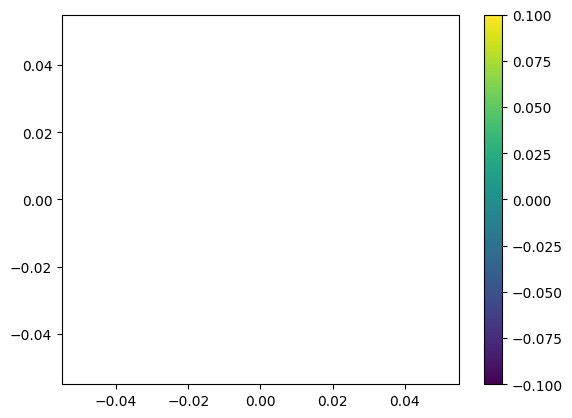

In [7]:
import matplotlib.pyplot as plt

# plt.hist(out_graph.detach().squeeze())
# plt.scatter(torch.arange(len(dataset)).numpy(), out_graph.detach().squeeze(), c=[dataset['data_list'][i]['graph_labels'] for i in range(len(dataset))])
cp = plt.scatter(colvar['phi'], colvar['psi'], c=out_graph[:, 0].detach().squeeze().numpy(), s=2)
plt.colorbar(cp)
# plt.ylim(0,1)
plt.show()